In [1]:
import duckdb
import numpy as np
import pandas as pd
import pyspark
from pyspark.shell import spark
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import ArrayType, FloatType, DecimalType, StringType, IntegerType
from pyspark.sql.functions import size
from pyspark.storagelevel import StorageLevel
from pyspark import SparkContext
from pyspark.sql.functions import col,when
from pyspark.sql import SparkSession
from pyspark.pandas.spark import functions as SF

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/22 11:21:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.2.0
      /_/

Using Python version 3.9.7 (default, Oct 10 2021 15:08:54)
Spark context Web UI available at http://3fb05e2fcdf0:4040
Spark context available as 'sc' (master = local[*], app id = local-1647948125710).
SparkSession available as 'spark'.


#### Connect to database and get all CSVs in one table

In [2]:
con = duckdb.connect(database=':memory:')

In [325]:
con.execute('''DROP TABLE train''')

In [4]:
con.execute('''
CREATE TABLE train(num INT, tconst VARCHAR, primaryTitle VARCHAR, originalTitle VARCHAR, startYear varchar,
endYear varchar, runtimeMinutes VARCHAR, numVotes FLOAT, label BOOL);
''')

In [12]:
#With copy the CSVs are appended to one table
#This was run 8 times
con.execute('''
COPY train FROM 'train-8.csv' (AUTO_DETECT TRUE)
''')

In [13]:
con.execute(''' SELECT * FROM train''').fetch_df()

,num,tconst,primarytitle,originaltitle,startyear,endyear,runtimeminutes,numvotes,label
0,4,tt0010600,The Doll,Die Puppe,1919,\N,66,1898.0,True
1,7,tt0011841,Way Down East,Way Down East,1920,\N,145,5376.0,True
2,9,tt0012494,Déstiny,Der müde Tod,1921,\N,97,5842.0,True
3,25,tt0015163,The Navigator,The Navigator,1924,\N,59,9652.0,True
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,\N,93,17887.0,True
...,...,...,...,...,...,...,...,...,...
7954,9966,tt9625664,Trauma Center,NaN,2019,\N,87,12951.0,False
7955,9981,tt9741310,Slaxx,Slaxx,2020,\N,77,2464.0,False
7956,9982,tt9742392,Kindred,Kindred,2020,\N,101,1719.0,False
7957,9996,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,NaN,2020,\N,111,4144.0,True


Get the JSONs into different tables

In [14]:
jsonStr = 'writing.json'
# Convert JSON to DataFrame Using read_json()
df = pd.read_json(jsonStr)
con.execute("CREATE TABLE writing AS SELECT * FROM 'df'");

In [15]:
con.execute("SELECT * FROM writing").fetchdf()

,movie,writer
0,tt0003740,nm0195339
1,tt0003740,nm0515385
2,tt0003740,nm0665163
3,tt0003740,nm0758215
4,tt0008663,nm0406585
...,...,...
22423,tt9904802,nm0942647
22424,tt9904802,nm3853396
22425,tt9911196,nm2063122
22426,tt9911196,nm0277932


In [16]:
jsonStr2 = 'directing.json'
# Convert JSON to DataFrame Using read_json()
df2 = pd.read_json(jsonStr2)
con.execute("CREATE TABLE directing AS SELECT * FROM 'df2'");

In [17]:
con.execute("SELECT * FROM directing").fetchdf()

,movie,director
0,tt0003740,nm0665163
1,tt0008663,nm0803705
2,tt0009369,nm0428059
3,tt0009369,nm0949648
4,tt0010307,nm0304098
...,...,...
11157,tt9850344,nm0284774
11158,tt9850386,nm0550881
11159,tt9900782,nm7992231
11160,tt9904802,nm0052054


#### From DB to Spark Df and begin preprocessing

In [110]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [268]:
# This gives an error, not sure why
# from pyspark.sql import SQLContext
# sqlContext = SQLContext(sc)
# train_df = sqlContext.sql(con.execute(''' SELECT * FROM train''').fetch_df())

In [18]:
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("IMDB") \
    .getOrCreate()

In [232]:
train_df=spark.createDataFrame(con.execute("SELECT * FROM train").fetchdf().where(pd.notnull(con.execute("SELECT * FROM train").fetchdf()),
                                                                                  None))

In [77]:
train_df.show()

+---+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|num|   tconst|        primarytitle|       originaltitle|startyear|endyear|runtimeminutes|numvotes|label|
+---+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|  4|tt0010600|            The Doll|           Die Puppe|     1919|     \N|            66|  1898.0| true|
|  7|tt0011841|       Way Down East|       Way Down East|     1920|     \N|           145|  5376.0| true|
|  9|tt0012494|             Déstiny|        Der müde Tod|     1921|     \N|            97|  5842.0| true|
| 25|tt0015163|       The Navigator|       The Navigator|     1924|     \N|            59|  9652.0| true|
| 38|tt0016220|The Phantom of th...|The Phantom of th...|     1925|     \N|            93| 17887.0| true|
| 42|tt0016630|     Báttling Bútlér|     Battling Butler|     1926|     \N|            77|  3285.0| true|
| 81|tt0021015|Juno and the Paycock|          

In [78]:
train_df.printSchema()

root
 |-- num: long (nullable = true)
 |-- tconst: string (nullable = true)
 |-- primarytitle: string (nullable = true)
 |-- originaltitle: string (nullable = true)
 |-- startyear: string (nullable = true)
 |-- endyear: string (nullable = true)
 |-- runtimeminutes: string (nullable = true)
 |-- numvotes: double (nullable = true)
 |-- label: boolean (nullable = true)



Check for duplicates - There are none

In [79]:
train_df = train_df.dropDuplicates(['tconst'])
train_df.show()

+---+---------+--------------------+-----------------+---------+-------+--------------+--------+-----+
|num|   tconst|        primarytitle|    originaltitle|startyear|endyear|runtimeminutes|numvotes|label|
+---+---------+--------------------+-----------------+---------+-------+--------------+--------+-----+
|  2|tt0009369|              Mickey|           Mickey|     1918|     \N|            93|  1119.0|false|
|  4|tt0010600|            The Doll|        Die Puppe|     1919|     \N|            66|  1898.0| true|
|  5|tt0011439|   The Mark of Zorro|The Mark of Zorro|     1920|     \N|            79|  2439.0| true|
|  6|tt0011607|  The Parson's Widow|       Prästänkan|     1920|     \N|            94|  1264.0| true|
|  7|tt0011841|       Way Down East|    Way Down East|     1920|     \N|           145|  5376.0| true|
|  8|tt0012349|             The Kid|             null|     1921|     \N|            68|121452.0| true|
|  9|tt0012494|             Déstiny|     Der müde Tod|     1921|     \N| 

In [80]:
train_df.count()

7959

##### Drop rows that have null values in runtimeminutes/numvotes

In [233]:
train_df = train_df.dropna(subset=["runtimeminutes","numvotes"])
train_df.show()

+---+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|num|   tconst|        primarytitle|       originaltitle|startyear|endyear|runtimeminutes|numvotes|label|
+---+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|  4|tt0010600|            The Doll|           Die Puppe|     1919|     \N|            66|  1898.0| true|
|  7|tt0011841|       Way Down East|       Way Down East|     1920|     \N|           145|  5376.0| true|
|  9|tt0012494|             Déstiny|        Der müde Tod|     1921|     \N|            97|  5842.0| true|
| 25|tt0015163|       The Navigator|       The Navigator|     1924|     \N|            59|  9652.0| true|
| 38|tt0016220|The Phantom of th...|The Phantom of th...|     1925|     \N|            93| 17887.0| true|
| 42|tt0016630|     Báttling Bútlér|     Battling Butler|     1926|     \N|            77|  3285.0| true|
| 81|tt0021015|Juno and the Paycock|          

##### Add YearSinceRealease feature

In [234]:
from pyspark.sql.functions import when

Replace \N with 2022 in endyear

In [235]:
train_df = train_df.withColumn("endyear", when(train_df.endyear == "\\N","2022")
                                 .otherwise(train_df.endyear))

Swap start and endyear where necesseary

In [236]:
train_df = train_df.withColumn("startyear", when(train_df.startyear == "\\N", train_df.endyear)
                              .otherwise(train_df.startyear))

In [237]:
train_df = train_df.withColumn("endyear", when(train_df.endyear == train_df.startyear, "2022")
                              .otherwise(train_df.endyear))

Check if it was done correctly

In [86]:
test1 = train_df.filter(train_df.primarytitle == "The Philadelphia Story")
test1.show()

+---+---------+--------------------+-------------+---------+-------+--------------+--------+-----+
|num|   tconst|        primarytitle|originaltitle|startyear|endyear|runtimeminutes|numvotes|label|
+---+---------+--------------------+-------------+---------+-------+--------------+--------+-----+
|272|tt0032904|The Philadelphia ...|         null|     1940|   2022|           112| 66874.0| true|
+---+---------+--------------------+-------------+---------+-------+--------------+--------+-----+



In [87]:
test2 = train_df.filter(train_df.primarytitle == "The Thief of Bagdad")
test2.show()

+---+---------+-------------------+-------------+---------+-------+--------------+--------+-----+
|num|   tconst|       primarytitle|originaltitle|startyear|endyear|runtimeminutes|numvotes|label|
+---+---------+-------------------+-------------+---------+-------+--------------+--------+-----+
| 31|tt0015400|The Thief of Bagdad|         null|     1924|   2022|           155|  6001.0| true|
|279|tt0033152|The Thief of Bagdad|         null|     1940|   2022|           106| 12840.0| true|
+---+---------+-------------------+-------------+---------+-------+--------------+--------+-----+



#### It works!

New feature: YearSinceRelease

In [238]:
train_df = train_df.withColumn('YearSinceRealease', ( train_df['endyear'] - train_df['startyear'] ))

Check how many rows have \N in runtimeminutes column

In [89]:
print(train_df.where(train_df.runtimeminutes == '\\N').count())

12


In [239]:
#They are few, so we can drop them
train_df=train_df.where(train_df.runtimeminutes != '\\N')

In [91]:
train_df.show()

+---+---------+--------------------+-----------------+---------+-------+--------------+--------+-----+-----------------+
|num|   tconst|        primarytitle|    originaltitle|startyear|endyear|runtimeminutes|numvotes|label|YearSinceRealease|
+---+---------+--------------------+-----------------+---------+-------+--------------+--------+-----+-----------------+
|  2|tt0009369|              Mickey|           Mickey|     1918|   2022|            93|  1119.0|false|            104.0|
|  4|tt0010600|            The Doll|        Die Puppe|     1919|   2022|            66|  1898.0| true|            103.0|
|  5|tt0011439|   The Mark of Zorro|The Mark of Zorro|     1920|   2022|            79|  2439.0| true|            102.0|
|  6|tt0011607|  The Parson's Widow|       Prästänkan|     1920|   2022|            94|  1264.0| true|            102.0|
|  7|tt0011841|       Way Down East|    Way Down East|     1920|   2022|           145|  5376.0| true|            102.0|
|  8|tt0012349|             The 

#### Additional data

In [35]:
con.execute('''
CREATE TABLE additional_data AS SELECT * FROM 'movies_info.csv';
''')

In [36]:
con.execute('''
SELECT * FROM additional_data''').fetch_df()

,imdb_id,adult,belongs_to_collection,budget,id,original_language,original_title,overview,popularity,production_companies,...,runtime,tagline,title,video,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list
0,tt0010600,False,NaN,0.0,48256.0,de,Die Puppe,The misadventures of an effete young man who m...,4.861,"[{'id': 12950, 'logo_path': None, 'name': 'Pro...",...,66.0,NaN,The Doll,False,7.3,60.0,"['Comedy', 'Fantasy']",['Projektions-AG Union (PAGU)'],['DE'],[]
1,tt0011841,False,NaN,0.0,31509.0,en,Way Down East,A naive country girl is tricked into a sham ma...,7.617,"[{'id': 4759, 'logo_path': None, 'name': 'D.W....",...,145.0,A simple story for plain people.,Way Down East,False,7.0,70.0,"['Drama', 'Action', 'Romance']","['D.W. Griffith Productions', 'United Artists']",['US'],[]
2,tt0012494,False,NaN,0.0,29267.0,de,Der müde Tod,As a young couple stops and rests in a small v...,7.593,"[{'id': 6762, 'logo_path': None, 'name': 'Decl...",...,105.0,Love is Stronger Than Death,Destiny,False,7.5,107.0,"['Drama', 'Fantasy', 'Thriller']",['Decla-Bioscop'],['DE'],['de']
3,tt0015163,False,NaN,0.0,32318.0,en,The Navigator,The wealthy and impulsive Rollo Treadway decid...,7.881,"[{'id': 12190, 'logo_path': None, 'name': 'Bus...",...,65.0,"Hurry! Hurry! Throw out the ""laff"" line!",The Navigator,False,7.3,152.0,"['Action', 'Comedy', 'Romance']",['Buster Keaton Productions'],['US'],[]
4,tt0016220,False,NaN,0.0,964.0,en,The Phantom of the Opera,"A grotesquely disfigured composer known as ""Th...",12.830,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...",...,101.0,The greatest horror film of modern cinema!,The Phantom of the Opera,False,7.2,243.0,"['Drama', 'Horror']",['Universal Pictures'],['US'],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7919,tt9625664,False,NaN,0.0,641790.0,en,Trauma Center,Lt. Wakes is a vengeful police detective deter...,21.290,"[{'id': 121204, 'logo_path': None, 'name': 'Bo...",...,87.0,The enemy is closer than you think,Trauma Center,False,5.7,310.0,"['Action', 'Thriller']","['BondIt Media Capital', 'Buffalo 8', 'Pimient...",['US'],"['en', 'es']"
7920,tt9741310,False,NaN,0.0,605133.0,en,Slaxx,When a possessed pair of jeans begins to kill ...,7.712,"[{'id': 62055, 'logo_path': None, 'name': 'EMA...",...,77.0,An ass to die for.,Slaxx,False,5.8,98.0,"['Comedy', 'Horror']","['EMAfilms', 'Entertainment Squad']",['CA'],"['en', 'hi']"
7921,tt9742392,False,NaN,0.0,717672.0,en,Kindred,When her boyfriend Ben suddenly dies in an acc...,5.826,"[{'id': 137874, 'logo_path': None, 'name': 'Re...",...,101.0,Family is everything.,Kindred,False,5.9,11.0,"['Drama', 'Mystery', 'Horror', 'Thriller']","['Reiver Pictures', 'IFC Midnight', 'Head Gear...",['GB'],['en']
7922,tt9850386,False,NaN,0.0,730009.0,en,The Bee Gees: How Can You Mend a Broken Heart,The story of the triumphs and hurdles of broth...,9.072,"[{'id': 862, 'logo_path': '/udTjbqPmcTbfrihMuL...",...,111.0,NaN,The Bee Gees: How Can You Mend a Broken Heart,False,8.0,37.0,"['Music', 'Documentary']","['The Kennedy/Marshall Company', 'White Horse ...",['US'],['en']


In [226]:
moredata_df=spark.createDataFrame(con.execute("SELECT * FROM additional_data").fetchdf().where(pd.notnull(con.execute("SELECT * FROM additional_data").fetchdf()),
                                                                                  None))

In [69]:
moredata_df.count()

7924

In [227]:
writers_df=spark.createDataFrame(con.execute("SELECT * FROM writing").fetchdf().where(pd.notnull(con.execute("SELECT * FROM writing").fetchdf()),
                                                                                  None))

In [228]:
directors_df=spark.createDataFrame(con.execute("SELECT * FROM directing").fetchdf().where(pd.notnull(con.execute("SELECT * FROM directing").fetchdf()),
                                                                                  None))

In [41]:
writers_df.show()

+---------+---------+
|    movie|   writer|
+---------+---------+
|tt0003740|nm0195339|
|tt0003740|nm0515385|
|tt0003740|nm0665163|
|tt0003740|nm0758215|
|tt0008663|nm0406585|
|tt0008663|nm0596410|
|tt0008663|nm0803705|
|tt0009369|nm0215874|
|tt0009369|nm0370271|
|tt0010307|nm0304098|
|tt0010600|nm0006782|
|tt0010600|nm0473134|
|tt0010600|nm0523932|
|tt0010600|nm0932559|
|tt0011439|nm0191547|
|tt0011439|nm0001196|
|tt0011439|nm1491939|
|tt0011607|nm0003433|
|tt0011607|nm0418114|
|tt0011841|nm0662461|
+---------+---------+
only showing top 20 rows



In [42]:
directors_df.show()

+---------+---------+
|    movie| director|
+---------+---------+
|tt0003740|nm0665163|
|tt0008663|nm0803705|
|tt0009369|nm0428059|
|tt0009369|nm0949648|
|tt0010307|nm0304098|
|tt0010600|nm0523932|
|tt0011439|nm0629243|
|tt0011607|nm0003433|
|tt0011841|nm0000428|
|tt0012349|nm0000122|
|tt0012494|nm0000485|
|tt0012532|nm0000428|
|tt0013257|nm0159725|
|tt0013556|nm0245385|
|tt0013933|nm0258477|
|tt0014109|nm0830249|
|tt0014142|nm0941637|
|tt0014341|nm0090007|
|tt0014341|nm0000036|
|tt0014358|nm0000122|
+---------+---------+
only showing top 20 rows



##### Merge all dataframe togerther (inito_numpy writers, directors, extra data)

Issues with merging

In [172]:
from pyspark.sql.functions import monotonically_increasing_id
train_df = train_df.withColumn("tconst",monotonically_increasing_id() )
#customers_df.show()
moredata_df = moredata_df.withColumn( "imdb_id", monotonically_increasing_id() )
#orders_df.show()
horiztnlcombined_data = train_df.join(moredata_df, train_df.tconst == moredata_df.imdb_id, 'inner')
horiztnlcombined_data.count()

990

This is not correct, shoul be like that:

In [240]:
train_pd = train_df.toPandas()
writers_pd = writers_df.toPandas()
directors_pd = directors_df.toPandas()
more_pd = moredata_df.toPandas()

In [242]:
train_pd.merge(more_pd, left_on = 'tconst', right_on = 'imdb_id', how = 'inner')

,num,tconst,primarytitle,originaltitle,startyear,endyear,runtimeminutes,numvotes,label,YearSinceRealease,...,runtime,tagline,title,video,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list
0,4,tt0010600,The Doll,Die Puppe,1919,2022,66,1898.0,True,103.0,...,66.0,None,The Doll,False,7.3,60.0,"['Comedy', 'Fantasy']",['Projektions-AG Union (PAGU)'],['DE'],[]
1,7,tt0011841,Way Down East,Way Down East,1920,2022,145,5376.0,True,102.0,...,145.0,A simple story for plain people.,Way Down East,False,7.0,70.0,"['Drama', 'Action', 'Romance']","['D.W. Griffith Productions', 'United Artists']",['US'],[]
2,9,tt0012494,Déstiny,Der müde Tod,1921,2022,97,5842.0,True,101.0,...,105.0,Love is Stronger Than Death,Destiny,False,7.5,107.0,"['Drama', 'Fantasy', 'Thriller']",['Decla-Bioscop'],['DE'],['de']
3,25,tt0015163,The Navigator,The Navigator,1924,2022,59,9652.0,True,98.0,...,65.0,"Hurry! Hurry! Throw out the ""laff"" line!",The Navigator,False,7.3,152.0,"['Action', 'Comedy', 'Romance']",['Buster Keaton Productions'],['US'],[]
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,2022,93,17887.0,True,97.0,...,101.0,The greatest horror film of modern cinema!,The Phantom of the Opera,False,7.2,243.0,"['Drama', 'Horror']",['Universal Pictures'],['US'],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,9966,tt9625664,Trauma Center,None,2019,2022,87,12951.0,False,3.0,...,87.0,The enemy is closer than you think,Trauma Center,False,5.7,310.0,"['Action', 'Thriller']","['BondIt Media Capital', 'Buffalo 8', 'Pimient...",['US'],"['en', 'es']"
7124,9981,tt9741310,Slaxx,Slaxx,2020,2022,77,2464.0,False,2.0,...,77.0,An ass to die for.,Slaxx,False,5.8,98.0,"['Comedy', 'Horror']","['EMAfilms', 'Entertainment Squad']",['CA'],"['en', 'hi']"
7125,9982,tt9742392,Kindred,Kindred,2020,2022,101,1719.0,False,2.0,...,101.0,Family is everything.,Kindred,False,5.9,11.0,"['Drama', 'Mystery', 'Horror', 'Thriller']","['Reiver Pictures', 'IFC Midnight', 'Head Gear...",['GB'],['en']
7126,9996,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,None,2020,2022,111,4144.0,True,2.0,...,111.0,None,The Bee Gees: How Can You Mend a Broken Heart,False,8.0,37.0,"['Music', 'Documentary']","['The Kennedy/Marshall Company', 'White Horse ...",['US'],['en']


In [124]:
# train_extra_w = train_extra.join(writers_df,train_extra.tconst == writers_df.movie, 'inner')
horiztnlcombined_data = horiztnlcombined_data.withColumn("tconst",monotonically_increasing_id() )
#customers_df.show()
writers_df = writers_df.withColumn( "movie", monotonically_increasing_id() )
#orders_df.show()
merged = horiztnlcombined_data.join(writers_df, horiztnlcombined_data.tconst == writers_df.movie, 'left')
#horiztnlcombined_data.show()

In [125]:
#final_df = train_extra_w.join(directors_df,train_extra_w.tconst == directors_df.movie, 'inner')
merged = merged.withColumn("tconst",monotonically_increasing_id() )
#customers_df.show()
directors_df = directors_df.withColumn( "movie", monotonically_increasing_id() )
#orders_df.show()
final_df = merged.join(directors_df, merged.tconst == directors_df.movie, 'left')

Keep useful columns

In [126]:
cols = ("num","tconst","primarytitle","originaltitle", "endyear","imdb_id", "belongs_to_collection", "budget",
        "id", "original_title", "overview", "tagline", "title", "video", "production_companies", "movie", "release_date",
        "revenue", "runtime")
final_df = final_df.drop(*cols)
#final_df.show()

In [127]:
final_df.toPandas()

,startyear,runtimeminutes,numvotes,label,YearSinceRealease,adult,original_language,popularity,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list,writer,director
0,1925,93,17887.0,True,97.0,False,en,2.526,3.2,26.0,['Horror'],"['Sigmund Neufeld Productions', 'PRC']",['US'],['en'],nm0195339,nm0665163
1,1925,143,7539.0,True,97.0,False,en,5.176,6.7,31.0,"['Thriller', 'Crime', 'Drama', 'Mystery']",['Warner Bros. Pictures'],['US'],['en'],nm0515385,nm0803705
2,1955,80,3361.0,True,67.0,False,en,24.991,5.9,1190.0,['Comedy'],"['Milestone Entertainment', 'Lionsgate', 'Karz...","['CA', 'US']",['en'],nm0665163,nm0428059
3,1971,86,2054.0,True,51.0,False,en,3.783,7.6,29.0,"['Romance', 'Drama']",['Fox Film Corporation'],['US'],[],nm0758215,nm0949648
4,1989,84,3031.0,False,33.0,None,None,NaN,NaN,NaN,None,None,None,None,nm0406585,nm0304098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,2016,102,19970.0,False,6.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None
7153,2015,102,1178.0,False,7.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None
7154,2019,98,5066.0,False,3.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None
7155,2017,68,2255.0,False,5.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None


##### Encoding

Trying to encode with One Hot Encoder for spark dataframe

In [119]:
#   ##  import the required libraries
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

  ##  numeric indexing for the strings (indexing starts from 0)
indexer = StringIndexer(inputCol="genre_list", outputCol="GenreNumericIndex")

  ##  fit the indexer model and use it to transform the strings into numeric indices
final_df = indexer.fit(final_df).transform(final_df)

  ##  one-hot-encoding the numeric indices
ohe = OneHotEncoder(inputCol="GenreNumericIndex", outputCol="GenreOHEVector")

  ##  fit the ohe model and use it to transform the numeric indices into ohe vectors
final_df = ohe.fit(final_df).transform(final_df)

#final_df.show()
#   ##  get datatype of the ohe vector column
print(final_df.schema["GenreOHEVector"].dataType)

VectorUDT


Convert it to pandas dataframe in order to feed it to the model

In [128]:
final_pandas = final_df.toPandas()

In [129]:
final_pandas

,startyear,runtimeminutes,numvotes,label,YearSinceRealease,adult,original_language,popularity,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list,writer,director
0,1925,93,17887.0,True,97.0,False,en,2.526,3.2,26.0,['Horror'],"['Sigmund Neufeld Productions', 'PRC']",['US'],['en'],nm0195339,nm0665163
1,1925,143,7539.0,True,97.0,False,en,5.176,6.7,31.0,"['Thriller', 'Crime', 'Drama', 'Mystery']",['Warner Bros. Pictures'],['US'],['en'],nm0515385,nm0803705
2,1955,80,3361.0,True,67.0,False,en,24.991,5.9,1190.0,['Comedy'],"['Milestone Entertainment', 'Lionsgate', 'Karz...","['CA', 'US']",['en'],nm0665163,nm0428059
3,1971,86,2054.0,True,51.0,False,en,3.783,7.6,29.0,"['Romance', 'Drama']",['Fox Film Corporation'],['US'],[],nm0758215,nm0949648
4,1989,84,3031.0,False,33.0,None,None,NaN,NaN,NaN,None,None,None,None,nm0406585,nm0304098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,2016,102,19970.0,False,6.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None
7153,2015,102,1178.0,False,7.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None
7154,2019,98,5066.0,False,3.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None
7155,2017,68,2255.0,False,5.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None


#### ML Model 

In [155]:
final_pandas.isnull().sum()

startyear                    0
runtimeminutes               0
numvotes                     0
label                        0
YearSinceRealease            0
adult                     6167
original_language         6167
popularity                6167
vote_average              6167
vote_count                6167
genre_list                6167
production_list           6167
production_countr_list    6167
spoken_language_list      6167
writer                    5109
director                  6133
dtype: int64

In [213]:
pip install lightgbm

     |████████████████████████████████| 2.1 MB 1.4 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [160]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [165]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
final_pandas['startyear_Cat'] = labelencoder.fit_transform(final_pandas['startyear'])
final_pandas['writers_Cat'] = labelencoder.fit_transform(final_pandas['writer'])
final_pandas['directors_Cat'] = labelencoder.fit_transform(final_pandas['director'])
final_pandas

,startyear,runtimeminutes,numvotes,label,YearSinceRealease,adult,original_language,popularity,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list,writer,director,startyear_Cat,writers_Cat,directors_Cat
0,1925,93,17887.0,True,97.0,False,en,2.526,3.2,26.0,['Horror'],"['Sigmund Neufeld Productions', 'PRC']",['US'],['en'],nm0195339,nm0665163,7,275,330
1,1925,143,7539.0,True,97.0,False,en,5.176,6.7,31.0,"['Thriller', 'Crime', 'Drama', 'Mystery']",['Warner Bros. Pictures'],['US'],['en'],nm0515385,nm0803705,7,695,389
2,1955,80,3361.0,True,67.0,False,en,24.991,5.9,1190.0,['Comedy'],"['Milestone Entertainment', 'Lionsgate', 'Karz...","['CA', 'US']",['en'],nm0665163,nm0428059,37,875,232
3,1971,86,2054.0,True,51.0,False,en,3.783,7.6,29.0,"['Romance', 'Drama']",['Fox Film Corporation'],['US'],[],nm0758215,nm0949648,53,985,450
4,1989,84,3031.0,False,33.0,None,None,NaN,NaN,NaN,None,None,None,None,nm0406585,nm0304098,71,551,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,2016,102,19970.0,False,6.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,98,1268,452
7153,2015,102,1178.0,False,7.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,97,1268,452
7154,2019,98,5066.0,False,3.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,101,1268,452
7155,2017,68,2255.0,False,5.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,99,1268,452


In [168]:
# To define the input and output feature
# 'num','tconst','primarytitle','originaltitle', 'endyear',
x = final_pandas.drop(['startyear',"adult", "original_language", 
                       "popularity","vote_average", "vote_count", "genre_list", "production_list", "production_countr_list",
                       "spoken_language_list", 'writer','director'],axis=1)
x = x.dropna()
x['runtimeminutes'] = x['runtimeminutes'].astype(float)
y = x['label']
x = x.drop(['label'],axis=1)
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)

In [169]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's binary_logloss: 0.502771	valid_0's binary_logloss: 0.545605
[40]	training's binary_logloss: 0.462388	valid_0's binary_logloss: 0.540061
[60]	training's binary_logloss: 0.436887	valid_0's binary_logloss: 0.541188
[80]	training's binary_logloss: 0.415628	valid_0's binary_logloss: 0.54321
[100]	training's binary_logloss: 0.395934	valid_0's binary_logloss: 0.546167


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [170]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.8279
Testing accuracy 0.7265


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

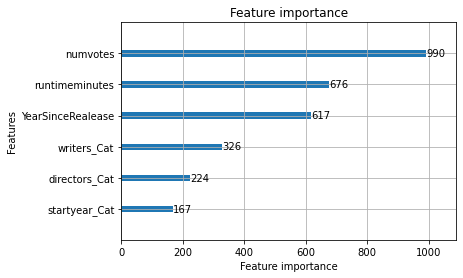

In [171]:
lgb.plot_importance(model)